In [ ]:
from os import listdir
from os.path import isfile, join

import time
import warnings

from PIL import Image

from skimage.metrics import structural_similarity as ssim
from sklearn.exceptions import NotFittedError
from sklearn.decomposition import IncrementalPCA, PCA

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (25,22)

from typing import Callable, Union, Literal, List, Dict

In [2]:
def time_counter(log_iters: int = 1):
    def wrapper(func: Callable):
        def get_time(*args, **kwargs):
            tic = time.perf_counter()
            res = func(*args, **kwargs)
            toc = time.perf_counter()
            if get_time.num_runs % log_iters == 0:
                print(f"Time spent for current {func.__name__} iteration is {toc - tic:0.4f} seconds.")
#                 print(f"Function {func.__name__} was already called {get_time.num_runs} times.")
            get_time.num_runs += 1
            return res, toc - tic
        get_time.num_runs = 1
        return get_time
    return wrapper

@time_counter(150)
def fit_transform_PCA(model: PCA, data: np.ndarray):
    model.fit(data)
    transformed = model.transform(data)
    
    return transformed

@time_counter(150)
def inverse_transform_PCA(model: PCA, transformed: np.ndarray):
    inverse = model.inverse_transform(transformed)
    return inverse

@time_counter(150)
def fit_transform_whole_IPCA(model: IncrementalPCA, data: np.ndarray, num_blocks: int):
    whole_transformed = None
    for i in range(len(data) // num_blocks + 1):
        
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(data))
        if start == end:
            continue
        batch = data[start: end]

        if len(batch) >= num_blocks:
            model.partial_fit(batch)
    
    for i in range(len(data) // num_blocks + 1):
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(data))
        if start == end:
            continue
        batch = data[start: end]
        
        try:
            transform_batch = model.transform(batch)
        except NotFittedError:
            continue
            
        if whole_transformed is None:
            whole_transformed = transform_batch
        else:
            whole_transformed = np.concatenate([whole_transformed, transform_batch], axis=0)
    
    return whole_transformed
        
@time_counter(150)
def inverse_transform_whole_IPCA(model: IncrementalPCA, transformed: np.ndarray, num_blocks: int):
    whole_inverse = None
    for i in range(len(transformed) // num_blocks + 1):
        
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(transformed))
        if start == end:
            continue
            
        batch = transformed[start: end]
        inv_batch = model.inverse_transform(batch)
        if whole_inverse is None:
            whole_inverse = inv_batch
        else:
            whole_inverse = np.concatenate([whole_inverse, inv_batch], axis=0)
    
    return whole_inverse

In [3]:
def benchmark_model_on_image(model_name: Literal['IPCA', 'PCA'], image: np.ndarray):
    ssim_arr = []

    transform_times = []
    inverse_times = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
       
        for num_components in range(1, min(image.shape[:2])):
            if model_name == 'PCA':
                model = PCA(n_components=num_components)
                transformed, transform_time = fit_transform_PCA(model, image)
                inverse, inverse_time = inverse_transform_PCA(model, transformed)
            else:
                model = IncrementalPCA(n_components=num_components)
                transformed, transform_time = fit_transform_whole_IPCA(model, image, num_blocks=num_components)
                inverse, inverse_time = inverse_transform_whole_IPCA(model, transformed, num_blocks=num_components)
            
            transform_times.append(transform_time)
            inverse_times.append(inverse_time)
            
            ssim_n = ssim(image, inverse, data_range=inverse.max() - inverse.min())
            ssim_arr.append(ssim_n)

            if ssim_n > 0.9:
                break

    return ssim_arr, transform_times, inverse_times

In [ ]:
def visualize_images(images: List[np.ndarray]):
    fig, ax = plt.subplots(nrows=5, ncols=3)
    
    for image, axis in zip(images, ax.flatten()):
        axis.imshow(image, cmap='gray')
        axis.set_axis_off()
    
    plt.show()

def visualize_plots(analysis_data: Dict[str, List[np.ndarray]]):
    pca_data = analysis_data['PCA']
    ipca_data = analysis_data['IPCA']
    
    fig, ax = plt.subplots(nrows=2, ncols=3)
    
    for i, model_data in enumerate([pca_data, ipca_data]):
        for j, key in model_data.keys():
            ax[i, j].plot(model_data[key])
    
    plt.show()

In [5]:
images = []

folder_path = './images'
for filename in listdir(folder_path):
    img = Image.open(f"{folder_path}/{filename}").convert('L')
    arr = np.array(img)
    images.append(arr)

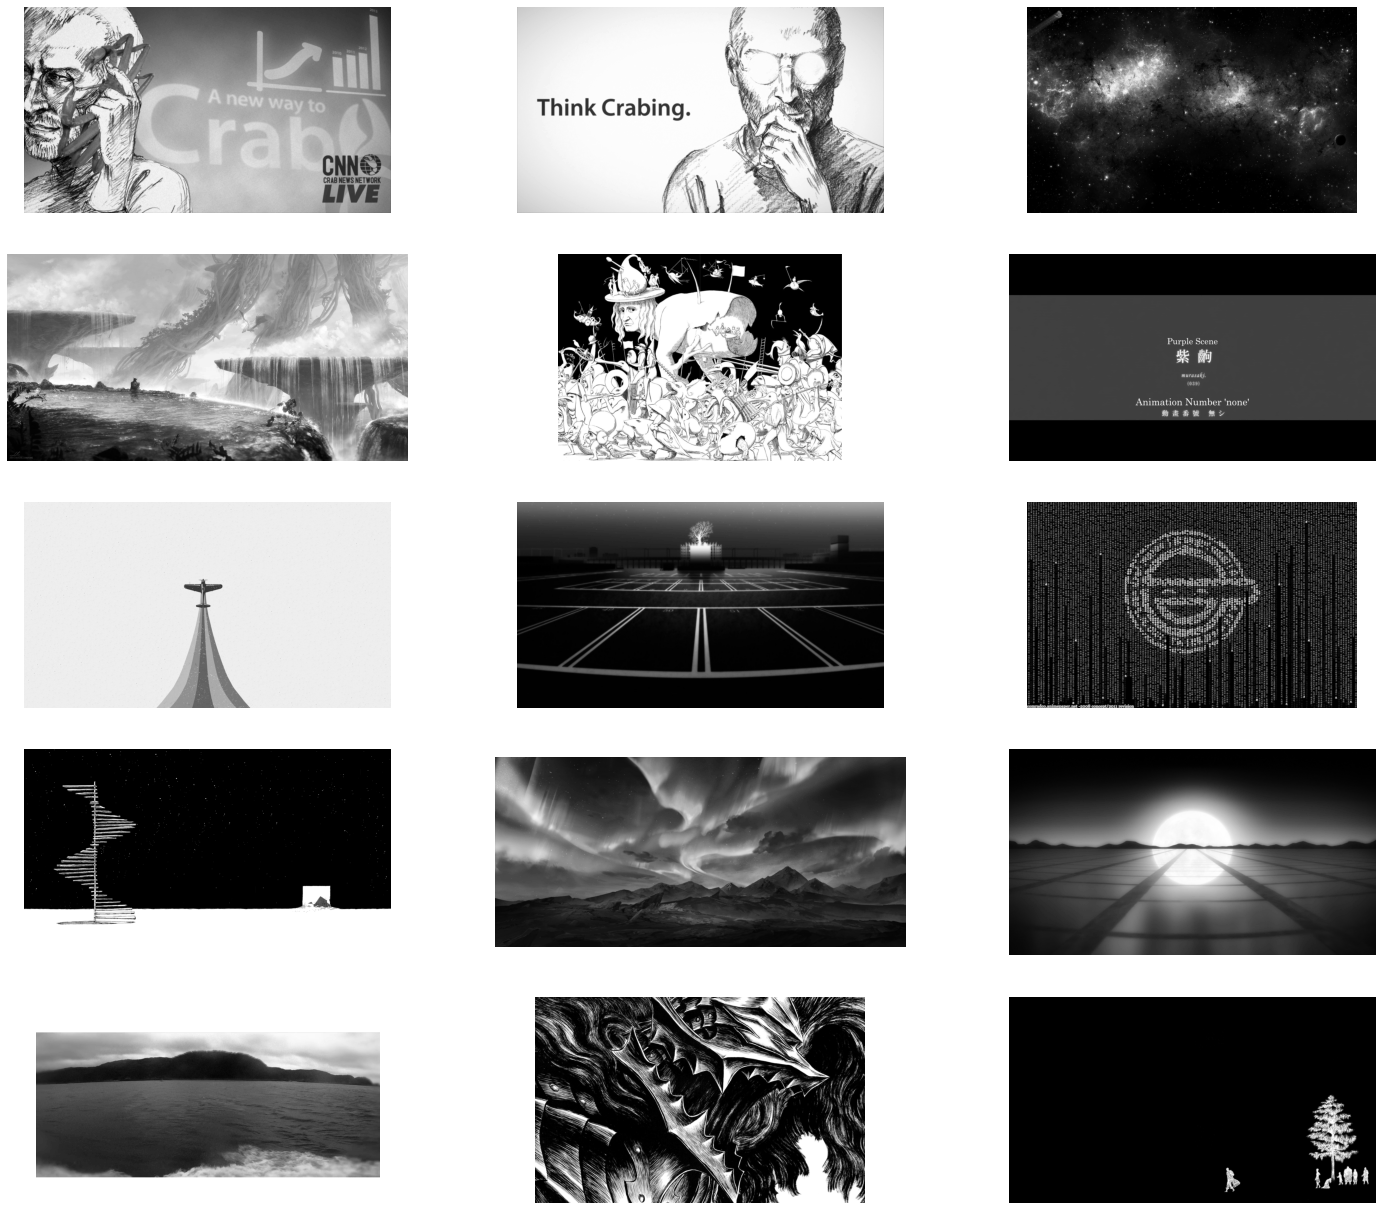

In [6]:
visualize_images(images)

In [ ]:
analysis_data = {
    'PCA': {
        'ssim': [], 'transform_t': [], 'inv_t': []
    }, 'IPCA' : {
        'ssim': [], 'transform_t': [], 'inv_t': []
    }
}

for image in images:
    for model_name in ['PCA', 'IPCA']:
        ssim_arr, transform_times, inverse_times = benchmark_model_on_image(model_name, image)
        analysis_data[model_name]['ssim'].append(ssim_arr)
        analysis_data[model_name]['transform_t'].append(transform_times)
        analysis_data[model_name]['inv_t'].append(inverse_times)

Time spent for current fit_transform_PCA iteration is 0.0789 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0069 seconds.
Time spent for current fit_transform_whole_IPCA iteration is 0.1468 seconds.
Time spent for current inverse_transform_whole_IPCA iteration is 0.0571 seconds.
Time spent for current fit_transform_whole_IPCA iteration is 0.1264 seconds.
Time spent for current inverse_transform_whole_IPCA iteration is 0.0454 seconds.
Time spent for current fit_transform_PCA iteration is 0.0333 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0043 seconds.
Time spent for current fit_transform_PCA iteration is 0.1027 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0082 seconds.
Time spent for current fit_transform_PCA iteration is 0.1784 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0112 seconds.
Time spent for current fit_transform_whole_IPCA iteration is 0.1499 seconds.
Time spent for current inverse_

In [ ]:
for 

In [4]:
img = Image.open('1632441447737.png').convert('L')

In [5]:
arr = np.array(img)

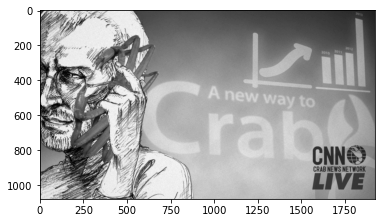

In [6]:
plt.imshow(arr, cmap='gray')

In [8]:
ssim_arr, transform_times, inverse_times = benchmark_model_on_image('PCA', arr)

Time spent for current fit_transform_PCA iteration is 0.0545 seconds.
Function fit_transform_PCA was already called 0 times.
Time spent for current inverse_transform_PCA iteration is 0.0069 seconds.
Function inverse_transform_PCA was already called 0 times.
Time spent for current fit_transform_PCA iteration is 0.0453 seconds.
Function fit_transform_PCA was already called 50 times.
Time spent for current inverse_transform_PCA iteration is 0.0041 seconds.
Function inverse_transform_PCA was already called 50 times.
Time spent for current fit_transform_PCA iteration is 0.0840 seconds.
Function fit_transform_PCA was already called 100 times.
Time spent for current inverse_transform_PCA iteration is 0.0063 seconds.
Function inverse_transform_PCA was already called 100 times.


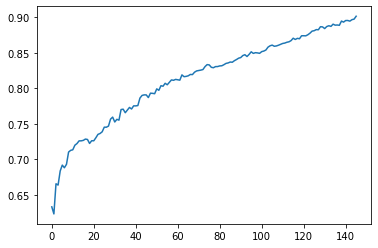

In [10]:
plt.plot(ssim_arr)

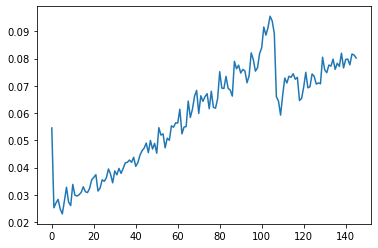

In [13]:
plt.plot(transform_times)

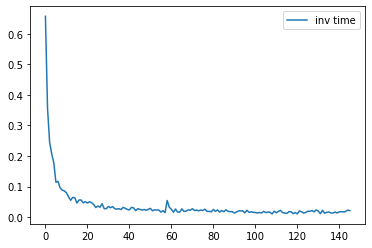

In [12]:
plt.plot(inverse_times, label='inv time')
plt.legend()

In [11]:
ssim_arr, transform_times, inverse_times = benchmark_model_on_image('IPCA', arr)

Time spent for current fit_transform_whole_IPCA iteration is 0.3875 seconds.
Function fit_transform_whole_IPCA was already called 0 times.
Time spent for current inverse_transform_whole_IPCA iteration is 0.6572 seconds.
Function inverse_transform_whole_IPCA was already called 0 times.
Current SSIM is: 0.7936
Time spent for current fit_transform_whole_IPCA iteration is 0.2034 seconds.
Function fit_transform_whole_IPCA was already called 50 times.
Time spent for current inverse_transform_whole_IPCA iteration is 0.0288 seconds.
Function inverse_transform_whole_IPCA was already called 50 times.
Current SSIM is: 0.8535
Time spent for current fit_transform_whole_IPCA iteration is 0.2054 seconds.
Function fit_transform_whole_IPCA was already called 100 times.
Time spent for current inverse_transform_whole_IPCA iteration is 0.0151 seconds.
Function inverse_transform_whole_IPCA was already called 100 times.


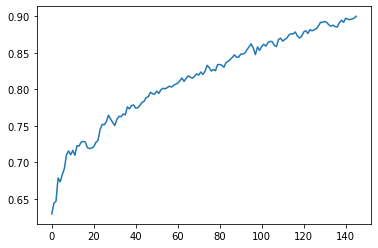

In [13]:
plt.plot(ssim_arr)

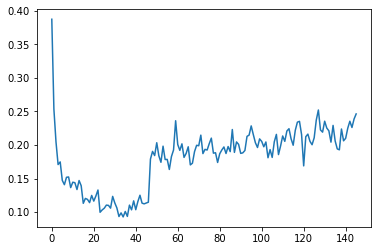

In [14]:
plt.plot(transform_times)

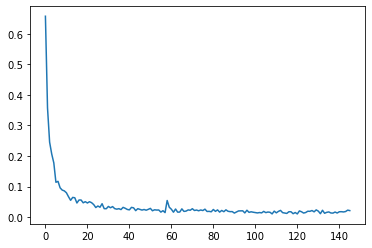

In [15]:
plt.plot(inverse_times)

In [12]:
arr.shape

(1080, 1920)

In [5]:
pca = IncrementalPCA()
pca.fit(arr)
transformed = pca.transform(arr)

/home/ippk93/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/ippk93/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


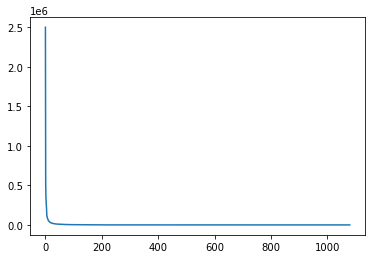

In [6]:
plt.plot(pca.explained_variance_)

In [7]:
n_comps = 10
pca = IncrementalPCA(n_components=n_comps)

In [8]:
for i in range(len(arr) // n_comps):
    batch = arr[n_comps * i: n_comps * (i + 1)]
    pca.partial_fit(batch)

/home/ippk93/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/ippk93/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
arr_ = pca.transform(arr)

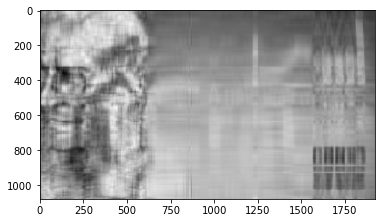

In [10]:
plt.imshow(pca.inverse_transform(arr_), cmap='gray')

In [11]:
pca = PCA(n_components=n_comps)
img_transformed = pca.fit_transform(arr)

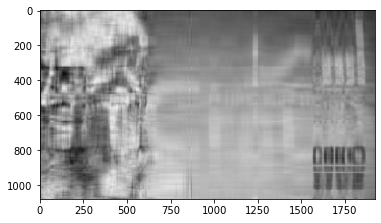

In [12]:
plt.imshow(pca.inverse_transform(img_transformed), cmap='gray')